# Trajectory Interpolation Test
- This is a test of using the new magnetic field function that interpolates the field. This is currently 3x faster than the model evaluation method.
- Would be nice to compare accuracy as well!

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import pickle as pkl
from datetime import datetime
from dateutil import parser

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['axes.axisbelow'] = True

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.io as pio
from plotly import tools
init_notebook_mode(True)

from hallprobecalib import hpc_ext_path
from hallprobecalib.hpcplots import scatter2d,scatter3d,histo

from mu2e import mu2e_ext_path
from mu2e.dataframeprod import DataFrameMaker
from mu2e.mu2eplots import mu2e_plot, mu2e_plot3d

In [4]:
#from mu2e.tools.fiteval import get_mag_field_function
#import odespy
from mu2e.tools.particletransport import ElectronSwimmer

In [5]:
plotdir = mu2e_ext_path + 'plots/trajectory_interp_test/'

In [6]:
df = DataFrameMaker(mu2e_ext_path+"datafiles/Mau13/Mu2e_DSMap_V13",input_type='pkl').data_frame

In [7]:
df.eval("Bx = Bx / 10000",inplace=True)
df.eval("By = By / 10000",inplace=True)
df.eval("Bz = Bz / 10000",inplace=True)

df.eval("X = X * 1000",inplace=True)
df.eval("Y = Y * 1000",inplace=True)
df.eval("Z = Z * 1000",inplace=True)

In [8]:
df.head(3)

,X,Y,Z,Bx,By,Bz,R,Phi,Bphi,Br
0,-1200.0,-1200.0,3071.0,0.128413,0.130710,0.044220,1.697056,-2.356194,-16.245222,-1832.273327
1,-1200.0,-1200.0,3096.0,0.131213,0.133514,0.041087,1.697056,-2.356194,-16.274707,-1871.903043
2,-1200.0,-1200.0,3121.0,0.133965,0.136270,0.037696,1.697056,-2.356194,-16.302671,-1910.848499


In [86]:
df_shift = DataFrameMaker(mu2e_ext_path+"datafiles/Mau13/Mu2e_DSMap_V13",input_type='pkl').data_frame

df_shift.eval("Bx = Bx / 10000",inplace=True)
df_shift.eval("By = By / 10000",inplace=True)
df_shift.eval("Bz = Bz / 10000",inplace=True)

df_shift.eval("X = X * 1000",inplace=True)
df_shift.eval("Y = Y * 1000",inplace=True)
df_shift.eval("Z = Z * 1000",inplace=True)

#df_shift.eval("X = X + 25",inplace=True)
#df_shift.eval("Y = Y + 25",inplace=True)
df_shift.eval("Z = Z + 25",inplace=True)

## Load Magnetic Field Functions

### Model Eval

In [9]:
from mu2e.tools.modeleval import get_mag_field_function

In [10]:
mag_field_func = get_mag_field_function('Mau13traj',units=('mm','T'),fastcart=True)

recreating fit with func_version=1000,
cfg_params(pitch1=0, ms_h1=0, ns_h1=0, pitch2=0, ms_h2=0, ns_h2=0, length1=10, ms_c1=50, ns_c1=4, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 10000}, bs_tuples=((1.0, 0, 7.873), (1.0, 0, 13.389)), bs_bounds=(0.1, 0.1, 5), version=1000)
Elapsed time was 1.93014 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 0
    # data points      = 46560
    # variables        = 0
    chi-square         = 764307.395
    reduced chi-square = 16.4155368
    Akaike info crit   = 130285.508
    Bayesian info crit = 130285.508
[[Variables]]
    pitch1:    0 (fixed)
    ms_h1:     0 (fixed)
    ns_h1:     0 (fixed)
    pitch2:    0 (fixed)
    ms_h2:     0 (fixed)
    ns_h2:     0 (fixed)
    length1:   10 (fixed)
    ms_c1:     50 (fixed)
    ns_c1:     4 (fixed)
    length2:   0 (fixed)
    ms_c2:     0 (fixed)
    ns_c2:     0 (fixed)
    Ac1_0_0:  -74613.8 (fixed)
    Bc1_0_0:   13334 (fixed)
    Dc1_0:     0.9452835 (fixed)
  

### Interp

In [19]:
from mu2e.tools.mapinterp import get_df_interp_func

In [20]:
mau13_interp_func = get_df_interp_func(df,method='linear',ck=False)
mau13_interp_func_ck = get_df_interp_func(df,method='linear',ck=True)

In [87]:
mau13_interp_func_shift = get_df_interp_func(df_shift,method='linear',ck=True)

## Initial Test

In [118]:
#pos = np.array([-29.47, -54.59, -3944.4+10200.])
#pos = np.array([66.123, 25.369, 5722.239]) # tricky
pos = np.array([-3935.5+3904., -15.5, 6004.4])#-3935.3+10200.]) # offline -- datadump_verbose_01.log

#pos = np.array([400, 0, -3944.4+10200.]) # reflect!
#pos = np.array([400, 0, -4200.+10200.]) # reflect!
#mom = np.array([55,74,50])
#mom = np.array([70,70,30])
#mom = np.array([0,100,32]) # reflect!
#mom = np.array([89.170445,-54.032551,12.414314])

#mom = np.array([0,32,100])
#mom = np.array([-4.711,-98.305,-36.592]) # tricky
mom = np.array([91.2,-40.8,32.1]) # offline -- datadump_verbose_01.log


#timesteps = np.linspace(265.4e-9, 300.657e-9, 3501)#3525) # offline -- datadump_verbose_01.log
timesteps = np.linspace(0,4e-8,4000)  ## GOOD
#timesteps = np.linspace(0,8e-8,8000)

In [119]:
rtol=1e-8#12#10#8#6#8#10#8#5#4#3#2#5
atol=1e-8#12#10#8#6#8#10#8#5#4#3#2#3
swimmer_interp = ElectronSwimmer(mom,pos,mau13_interp_func,timesteps,'Dop853',rtol=rtol,atol=atol)
swimmer_interp_ck = ElectronSwimmer(mom,pos,mau13_interp_func_ck,timesteps,'Dop853',rtol=rtol,atol=atol)
swimmer_interp_shift = ElectronSwimmer(mom,pos,mau13_interp_func_shift,timesteps,'Dop853',rtol=rtol,atol=atol)

#swimmer_const = ElectronSwimmer(mom,pos,b_const,timesteps,'Dopri5',rtol=rtol,atol=atol)
swimmer_model = ElectronSwimmer(mom,pos,mag_field_func,timesteps,'Dop853',rtol=rtol,atol=atol)
swimmer_5 = ElectronSwimmer(mom,pos,mau13_interp_func,timesteps,'Dopri5',rtol=rtol,atol=atol)

In [27]:
## Line profiler run on normal event:
# r-6,a-6
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [68]:
#%lprun -f swimmer_interp.solve swimmer_interp.solve()
%lprun -f swimmer_interp_ck.solve swimmer_interp.solve()

swimming electron with [ -4.711 -98.305 -36.592] MeV, starting at [  66.123   25.369 5722.239] mm, for 4e-08 s
*** KeyboardInterrupt exception caught in code being profiled.

In [69]:
%prun swimmer_interp_ck.solve()

swimming electron with [ -4.711 -98.305 -36.592] MeV, starting at [  66.123   25.369 5722.239] mm, for 4e-08 s
init energy: 105.00143870945898 MeV
final energy: 105.0014680481475 MeV
energy difference: 2.9338688520397227e-05 MeV (2.794e-05%)
 

In [63]:
# NOT tricky event using ck_interp
# r-12, a-12
x_ck_12,t_ck_12 = swimmer_interp_ck.solve()
x_ck_12 = pd.DataFrame(x_ck_12[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_ck_12['t'] = pd.Series(t_ck_12,name='time')

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=1.9935e-08
init energy: 104.99648146930423 MeV
final energy: 104.9964814402677 MeV
energy difference: -2.9036527848802507e-08 MeV (-2.765e-08%)


In [57]:
# NOT tricky event using ck_interp
# r-10, a-10
x_ck_10,t_ck_10 = swimmer_interp_ck.solve()
x_ck_10 = pd.DataFrame(x_ck_10[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_ck_10['t'] = pd.Series(t_ck_10,name='time')

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=1.9935e-08
init energy: 104.99648146930423 MeV
final energy: 104.99648147373355 MeV
energy difference: 4.429324462762452e-09 MeV (4.219e-09%)


In [142]:
# Offline event -- datadump_verbos_01.log
# r-8, a-8
x_off,t_off = swimmer_interp_ck.solve()
x_off = pd.DataFrame(x_off[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_off['t'] = pd.Series(t_off,name='time')

swimming electron with [ 91.2 -40.8  32.1] MeV, starting at [ -31.5  -15.5 6004.4] mm, for 4e-08 s
Dop853 terminated at t=3.68992e-08
init energy: 104.94165579550956 MeV
final energy: 104.94166547803542 MeV
energy difference: 9.682525856646862e-06 MeV (9.227e-06%)


In [121]:
x_off ## 0 start time

,X,Y,Z,Vx,Vy,Vz,t
0,-31.500000,-15.500000,6004.400000,2.605359e+11,-1.165555e+11,9.170179e+10,0.000000e+00
1,-4.784408,-25.509595,6013.577121,2.729490e+11,-8.334277e+10,9.179432e+10,1.000250e-11
2,22.962347,-32.132815,6022.763532,2.811321e+11,-4.893351e+10,9.188916e+10,2.000500e-11
3,51.311714,-35.276725,6031.959948,2.849876e+11,-1.386399e+10,9.199596e+10,3.000750e-11
4,79.828742,-34.902342,6041.168040,2.844851e+11,2.132458e+10,9.212419e+10,4.001000e-11
5,108.078824,-31.024720,6050.390411,2.796617e+11,5.609438e+10,9.228293e+10,5.001250e-11
6,135.634352,-23.712178,6059.630546,2.706200e+11,8.991954e+10,9.248078e+10,6.001500e-11
7,162.081176,-13.084729,6068.892764,2.575260e+11,1.222935e+11,9.272573e+10,7.001750e-11
8,187.024788,0.688244,6078.182142,2.406057e+11,1.527371e+11,9.302501e+10,8.002001e-11
9,210.096112,17.391095,6087.504441,2.201409e+11,1.808054e+11,9.338495e+10,9.002251e-11


In [123]:
#x_off_bak = x_off

In [143]:
x_off.eval("Z = Z - 10200.",inplace=True)#10171.",inplace=True)#10035.",inplace=True)

In [144]:
df1 = x_off

fig = scatter3d(df1.X,df1.Y,df1.Z,scale_list=[df1.t],mode_list=['markers+lines'],units_list=[('mm','mm','mm')],inline=True);

In [132]:
gen_stepMCs = pd.read_pickle(mu2e_ext_path+"mc_steps_offline_datadump_verbose_01.p")

In [133]:
gen_stepMCs.columns

Index(['ind', 'parent', 'vol', 'eDep', 'noIonEDep', 'X', 'Y', 'Z', 'P', 'time',
       'endProc', 'EVTID', 'SUBID'],
      dtype='object')

In [137]:
gen_stepMCs.sort_values(by=["time"],inplace=True)

In [145]:
df1 = x_off
df2 = gen_stepMCs
fig = scatter3d([df1.X,df2.X],[df1.Y,df2.Y],[df1.Z,df2.Z],scale_list=[df1.t,df2.time],mode_list=2*['markers+lines'],
          units_list=2*[('mm','mm','mm')],colors_list=['Viridis','Hot'],inline=True);

In [89]:
##### SHIFTED +25 mm Z coordinate for tricky event
# r-8, a-8
x_ck_shift_z,t_ck_shift_z = swimmer_interp_shift.solve()
x_ck_shift_z = pd.DataFrame(x_ck_shift_z[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_ck_shift_z['t'] = pd.Series(t_ck_shift_z,name='time')

swimming electron with [ -4.711 -98.305 -36.592] MeV, starting at [  66.123   25.369 5722.239] mm, for 4e-08 s
init energy: 105.00143870945898 MeV
final energy: 105.0014680385493 MeV
energy difference: 2.9329090324381468e-05 MeV (2.793e-05%)


In [84]:
##### SHIFTED +25 mm Y coordinate for tricky event
# r-8, a-8
x_ck_shift_y,t_ck_shift_y = swimmer_interp_shift.solve()
x_ck_shift_y = pd.DataFrame(x_ck_shift_y[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_ck_shift_y['t'] = pd.Series(t_ck_shift_y,name='time')

swimming electron with [ -4.711 -98.305 -36.592] MeV, starting at [  66.123   25.369 5722.239] mm, for 4e-08 s
init energy: 105.00143870945898 MeV
final energy: 105.00146793543034 MeV
energy difference: 2.9225971360347103e-05 MeV (2.783e-05%)


In [78]:
##### SHIFTED +25 mm X coordinate for tricky event
# r-8, a-8
x_ck_shift_x,t_ck_shift_x = swimmer_interp_shift.solve()
x_ck_shift_x = pd.DataFrame(x_ck_shift_x[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_ck_shift_x['t'] = pd.Series(t_ck_shift_x,name='time')

swimming electron with [ -4.711 -98.305 -36.592] MeV, starting at [  66.123   25.369 5722.239] mm, for 4e-08 s
init energy: 105.00143870945898 MeV
final energy: 105.00146782123653 MeV
energy difference: 2.9111777550383522e-05 MeV (2.773e-05%)


In [67]:
# tricky event using ck_interp
# r-8, a-8
x_ck_8,t_ck_8 = swimmer_interp_ck.solve()
x_ck_8 = pd.DataFrame(x_ck_8[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_ck_8['t'] = pd.Series(t_ck_8,name='time')

swimming electron with [ -4.711 -98.305 -36.592] MeV, starting at [  66.123   25.369 5722.239] mm, for 4e-08 s
init energy: 105.00143870945898 MeV
final energy: 105.0014680481475 MeV
energy difference: 2.9338688520397227e-05 MeV (2.794e-05%)


In [23]:
# NOT tricky event using ck_interp
# r-6, a-6
x_ck,t_ck = swimmer_interp_ck.solve()
x_ck = pd.DataFrame(x_ck[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_ck['t'] = pd.Series(t_ck,name='time')

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=1.9935e-08
init energy: 104.99648146930423 MeV
final energy: 104.99648153771233 MeV
energy difference: 6.840809874120168e-08 MeV (6.515e-08%)


In [38]:
# tricky event
# r-8, a-8
x_i,t_i = swimmer_interp.solve()
x_i = pd.DataFrame(x_i[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_i['t'] = pd.Series(t_i,name='time')

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s


KeyboardInterrupt: 

In [ ]:
## DIDN'T TIME BUT TOOK ~3 minutes
# tricky event
# r-6, a-6
#%time x_i,t_i = swimmer_interp.solve()

In [19]:
# tricky event
# r-7, a-7
x_i,t_i = swimmer_interp.solve()
x_i = pd.DataFrame(x_i[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_i['t'] = pd.Series(t_i,name='time')

swimming electron with [ -4.711 -98.305 -36.592] MeV, starting at [  66.123   25.369 5722.239] mm, for 4e-08 s
init energy: 105.00143870945898 MeV
final energy: 105.00238597136521 MeV
energy difference: 0.0009472619062336207 MeV (0.0009021%)


In [ ]:
## DIDN'T TIME BUT TOOK ~3 minutes
# tricky event
# r-7, a-7
#%time x_i,t_i = swimmer_interp.solve()

In [60]:
# tricky event
# r-8, a-8
x_i,t_i = swimmer_interp.solve()
x_i = pd.DataFrame(x_i[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_i['t'] = pd.Series(t_i,name='time')

swimming electron with [ -4.711 -98.305 -36.592] MeV, starting at [  66.123   25.369 5722.239] mm, for 4e-08 s
init energy: 105.00143870945898 MeV
final energy: 105.00146812887071 MeV
energy difference: 2.9419411731623768e-05 MeV (2.802e-05%)


In [ ]:
## DIDN'T TIME BUT TOOK ~3-5 minutes
# tricky event
# r-8, a-8
#%time x_i,t_i = swimmer_interp.solve()

In [56]:
# r-10, a-10
x_i,t_i = swimmer_interp.solve()
x_i = pd.DataFrame(x_i[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_i['t'] = pd.Series(t_i,name='time')

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=1.9935e-08
init energy: 104.99648146930423 MeV
final energy: 104.99648150080151 MeV
energy difference: 3.1497279451286886e-08 MeV (3e-08%)


In [57]:
# r-10, a-10
%time x_i,t_i = swimmer_interp.solve()

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=1.9935e-08
init energy: 104.99648146930423 MeV
final energy: 104.99648146118386 MeV
energy difference: -8.120366601360729e-09 MeV (-7.734e-09%)
CPU times: user 53.7 s, sys: 817 ms, total: 54.6 s
Wall time: 54.5 s


In [52]:
# r-8, a-8
x_i,t_i = swimmer_interp.solve()
x_i = pd.DataFrame(x_i[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_i['t'] = pd.Series(t_i,name='time')

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=1.9935e-08
init energy: 104.99648146930423 MeV
final energy: 104.99648157511533 MeV
energy difference: 1.0581109677332279e-07 MeV (1.008e-07%)


In [54]:
# r-8, a-8
%time x_i,t_i = swimmer_interp.solve()

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=1.9935e-08
init energy: 104.99648146930423 MeV
final energy: 104.99648157511533 MeV
energy difference: 1.0581109677332279e-07 MeV (1.008e-07%)
CPU times: user 32.7 s, sys: 422 ms, total: 33.2 s
Wall time: 33.2 s


In [46]:
# r-5, a-5
x_i,t_i = swimmer_interp.solve()
x_i = pd.DataFrame(x_i[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_i['t'] = pd.Series(t_i,name='time')

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=1.9935e-08
init energy: 104.99648146930423 MeV
final energy: 104.99648144002164 MeV
energy difference: -2.928258879819623e-08 MeV (-2.789e-08%)


In [ ]:
# r-5, a-5
%time x_i,t_i = swimmer_interp.solve()

In [43]:
# r-4, a-4
x_i,t_i = swimmer_interp.solve()
x_i = pd.DataFrame(x_i[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_i['t'] = pd.Series(t_i,name='time')

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=1.9935e-08
init energy: 104.99648146930423 MeV
final energy: 104.99648145798491 MeV
energy difference: -1.1319315262880991e-08 MeV (-1.078e-08%)


In [44]:
# r-4, a-4
%time x_i,t_i = swimmer_interp.solve()

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=1.9935e-08
init energy: 104.99648146930423 MeV
final energy: 104.99648145798491 MeV
energy difference: -1.1319315262880991e-08 MeV (-1.078e-08%)
CPU times: user 22.2 s, sys: 279 ms, total: 22.5 s
Wall time: 22.5 s


In [41]:
# r-3, a-3
x_i,t_i = swimmer_interp.solve()
x_i = pd.DataFrame(x_i[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_i['t'] = pd.Series(t_i,name='time')

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=1.9935e-08
init energy: 104.99648146930423 MeV
final energy: 104.99648145798491 MeV
energy difference: -1.1319315262880991e-08 MeV (-1.078e-08%)


In [33]:
# r-3, a-3
%time x_i,t_i = swimmer_interp.solve()

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=1.9935e-08
init energy: 104.99648146930423 MeV
final energy: 104.99648145798491 MeV
energy difference: -1.1319315262880991e-08 MeV (-1.078e-08%)
CPU times: user 22.2 s, sys: 290 ms, total: 22.5 s
Wall time: 22.5 s


In [39]:
x_m,t_m = swimmer_model.solve()
x_m = pd.DataFrame(x_m[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_m['t'] = pd.Series(t_m,name='time')

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=2.0095e-08
init energy: 104.99648146930423 MeV
final energy: 104.99648162113083 MeV
energy difference: 1.5182659751644678e-07 MeV (1.446e-07%)


In [33]:
%time x_i,t_i = swimmer_interp.solve()

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=1.9935e-08
init energy: 104.99648146930423 MeV
final energy: 104.99648145798491 MeV
energy difference: -1.1319315262880991e-08 MeV (-1.078e-08%)
CPU times: user 22.2 s, sys: 290 ms, total: 22.5 s
Wall time: 22.5 s


In [29]:
%time x_m,t_m = swimmer_model.solve()

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=2.0095e-08
init energy: 104.99648146930423 MeV
final energy: 104.99648162432977 MeV
energy difference: 1.5502554617796704e-07 MeV (1.476e-07%)
CPU times: user 4min 51s, sys: 55.3 s, total: 5min 46s
Wall time: 1min


In [23]:
x_m['t'] = pd.Series(m_l,name='time')

In [28]:
df1_77 = df1
#df2_22 = df2

In [80]:
#x_ck_shift_x = x_ck_shift

In [90]:
df1 = x_ck_8#x_ck
#df1 = x_m
#df2 = x_m
df2 = x_ck_shift_z#x_ck_shift_y#x_ck_shift_x#x_i
#scatter3d(df1.X,df1.Y,df1.Z,scale_list=[df1.t],mode_list=['markers+lines'],units_list=[('mm','mm','mm')],inline=True)
fig = scatter3d([df1.X,df2.X],[df1.Y,df2.Y],[df1.Z,df2.Z],scale_list=[df1.t,df2.t],mode_list=2*['markers+lines'],
          units_list=2*[('mm','mm','mm')],colors_list=['Viridis','Hot'],inline=True)

In [ ]:
pkl.dump()

In [93]:
x_ck_8.tail(1)

,X,Y,Z,Vx,Vy,Vz,t
399,339.324966,246.803404,6932.993397,-2.419109e+11,3.310192e+10,1.739447e+11,3.990998e-09


In [94]:
x_ck_shift_x.tail(1)

,X,Y,Z,Vx,Vy,Vz,t
399,336.813778,247.246912,6929.555935,-2.430705e+11,3.339068e+10,1.722649e+11,3.990998e-09


In [95]:
x_ck_shift_y.tail(1)

,X,Y,Z,Vx,Vy,Vz,t
399,364.027182,241.329071,6954.465373,-2.367951e+11,5.816729e+10,1.744076e+11,3.990998e-09


In [96]:
x_ck_shift_z.tail(1)

,X,Y,Z,Vx,Vy,Vz,t
399,288.458647,245.208989,6940.471054,-2.437144e+11,-1.988439e+10,1.734396e+11,3.990998e-09


In [44]:
#x_i
x_i.tail(1)

,X,Y,Z,Vx,Vy,Vz,t
199,-51.082884,-114.418258,11993.784326,3.886457e+10,6.793592e+10,2.893919e+11,1.990498e-09


In [45]:
x_ck.tail(1)

,X,Y,Z,Vx,Vy,Vz,t
199,-51.089632,-114.416334,11993.782937,3.886793e+10,6.793537e+10,2.893915e+11,1.990498e-09


In [46]:
#x_ck_8
x_ck_8.tail(1)

,X,Y,Z,Vx,Vy,Vz,t
199,-51.089633,-114.416335,11993.782936,3.886793e+10,6.793537e+10,2.893915e+11,1.990498e-09


In [59]:
x_ck_10.tail(1)

,X,Y,Z,Vx,Vy,Vz,t
199,-51.089636,-114.416335,11993.78294,3.886794e+10,6.793536e+10,2.893915e+11,1.990498e-09


In [52]:
(x_ck_8.tail(1) - x_ck.tail(1)) / ((x_ck_8.tail(1) + x_ck.tail(1))/2)

,X,Y,Z,Vx,Vy,Vz,t
199,2.454820e-08,4.583232e-09,-1.115153e-10,2.447718e-08,-3.377616e-09,-2.554227e-10,0.0


In [60]:
(x_ck_10.tail(1) - x_ck.tail(1)) / ((x_ck_10.tail(1) + x_ck.tail(1))/2)

,X,Y,Z,Vx,Vy,Vz,t
199,7.661787e-08,1.067730e-08,1.873318e-10,5.831611e-08,-2.853883e-08,5.207611e-10,0.0


In [61]:
(x_ck_10.tail(1) - x_i.tail(1)) / ((x_ck_10.tail(1) + x_i.tail(1))/2)

,X,Y,Z,Vx,Vy,Vz,t
199,0.000132,-0.000017,-1.156220e-07,0.000087,-0.000008,-0.000001,0.0


In [53]:
(x_ck_8.tail(1) - x_i.tail(1)) / ((x_ck_8.tail(1) + x_i.tail(1))/2)

,X,Y,Z,Vx,Vy,Vz,t
199,0.000132,-0.000017,-1.159208e-07,0.000087,-0.000008,-0.000001,0.0


In [51]:
(x_ck.tail(1) - x_i.tail(1)) / ((x_ck.tail(1) + x_i.tail(1))/2)

,X,Y,Z,Vx,Vy,Vz,t
199,0.000132,-0.000017,-1.158093e-07,0.000087,-0.000008,-0.000001,0.0


In [70]:
df1 = x_ck_8#x_i
#df1 = x_m
#df2 = x_m
#df2 = df1_22
fig = scatter3d(df1.X,df1.Y,df1.Z,scale_list=[df1.t],mode_list=['markers+lines'],units_list=[('mm','mm','mm')],inline=True)
#fig = scatter3d(df2.X,df2.Y,df2.Z,scale_list=[df2.t],mode_list=['markers+lines'],units_list=[('mm','mm','mm')],inline=True)
#fig = scatter3d([df1.X,df2.X],[df1.Y,df2.Y],[df1.Z,df2.Z],scale_list=[df1.t,df2.t],mode_list=2*['markers+lines'],
          #units_list=2*[('mm','mm','mm')],colors_list=['Viridis','Hot'],inline=True)

In [24]:
#df1 = pkl.load(open(plotdir+"tricky_event_r-7_a-7_01.pkl",'rb'))
#df1 = pd.read_pickle(plotdir+"tricky_event_r-7_a-7_01.pkl")
df1 = pd.read_pickle(plotdir+"tricky_event_r-6_a-6_01.pkl")

In [31]:
#pkl.dump(df1,open(plotdir+"tricky_event_r-7_a-7_01.pkl",'wb'))
#df1.to_pickle(plotdir+"tricky_event_r-7_a-7_01.pkl")
df1.to_pickle(plotdir+"tricky_event_r-6_a-6_01.pkl")

In [72]:
filename = "interp_tricky_event_reflected_track"
plot(fig,filename=plotdir+filename+'.html',auto_open=False)
pio.write_image(fig,plotdir+filename+'.pdf')

In [34]:
df1 = x_i
#df1 = x_m
#df2 = x_m
df2 = df1_77
#scatter3d(df1.X,df1.Y,df1.Z,scale_list=[df1.t],mode_list=['markers+lines'],units_list=[('mm','mm','mm')],inline=True)
fig = scatter3d([df1.X,df2.X],[df1.Y,df2.Y],[df1.Z,df2.Z],scale_list=[df1.t,df2.t],mode_list=2*['markers+lines'],
          units_list=2*[('mm','mm','mm')],colors_list=['Viridis','Hot'],inline=True)

In [27]:
filename = "interp_vs_model_eval_tracks"
plot(fig,filename=plotdir+filename+'.html',auto_open=False)
pio.write_image(fig,plotdir+filename+'.pdf')

In [ ]:
df_small = df_out[::10]

df_small

df = df_small
scatter3d(df.X,df.Y,df.Z,scale_list=[df.time],mode_list=['markers+lines'],units_list=[('mm','mm','mm')],inline=True)

In [16]:
#timesteps = np.linspace(0,4e-8,4000)
timesteps = np.linspace(0,4e-8,4000)

In [ ]:
start = time.time()
for i,row in tqdm_notebook(enumerate(df.iloc[[1]].itertuples()), desc='particle #'):
    #print (i, row.X0)
    mom = np.array([row.Px0,row.Py0,row.Pz0])
    pos = np.array([row.X0,row.Y0,row.Z0])
    rtol = 1e-5
    atol = 1e-3
    swimmer = ElectronSwimmer(mom,pos,mag_field_func,timesteps,'Dop853',rtol=rtol,atol=atol)
    #swimmer = ElectronSwimmer(mom,pos,mag_field_func,timesteps,'Dop853',rtol=rtol,atol=atol)
    X, t = swimmer.solve()
    df_out = pd.DataFrame(X,columns=['X','Y','Z','Vx','Vy','Vz'])
    df_out['time'] = t
    df_out['event'] = i
    df_out.event = df_out.event.astype('category')
    df_out['E0'] = swimmer.init_E
    df_out['EF'] = swimmer.final_E
    pkl.dump(df_out,open(save_dir+run_name+f"{i:03d}_TESTING.p",'wb'))
stop = time.time()

In [ ]:
df_small = df_out[::10]

df_small

df = df_small
scatter3d(df.X,df.Y,df.Z,scale_list=[df.time],mode_list=['markers+lines'],units_list=[('mm','mm','mm')],inline=True)

## Gen Run 03

In [27]:
str(datetime.now())

'2019-05-07 13:17:30.328452'

In [9]:
# import data (first prepped in python 2)
df = pd.read_pickle(mu2e_ext_path+'root/ce_OLD.pkl')
# select good events only
df = df[df['de._status'] != -1000]

In [10]:
df = df.sample(n=100).reset_index(drop=True)

df['X0'] = df['demcgen_x']
df['Y0'] = df['demcgen_y']
df['Z0'] = df['demcgen_z']+10200.

df = df[['X0','Y0','Z0']]

#df

#Great, now let's generate random theta and phi (from standard spherical coordinates) to denote the direction of the momentum vector. The magnitude is always 105 MeV!

#df['Phi0'] = np.random.uniform(0,2*np.pi,200)
df['Phi0'] = np.random.uniform(0,2*np.pi,100)

#df['Theta0'] = np.random.uniform(0,np.pi,200)
#df['Theta0'] = np.random.uniform(0,np.pi,100)
# FIXED THETA
df['CosTheta0'] = np.random.uniform(-1,1,100)
df['Theta0'] = np.arccos(df['CosTheta0'])

mom = 105.

df['Px0'] = mom * np.sin(df['Theta0'])*np.cos(df['Phi0'])
df['Py0'] = mom * np.sin(df['Theta0'])*np.sin(df['Phi0'])
df['Pz0'] = mom * np.cos(df['Theta0'])
df['Pt0'] = mom * np.sin(df['Theta0'])

#Let's check out our generated starting conditions!

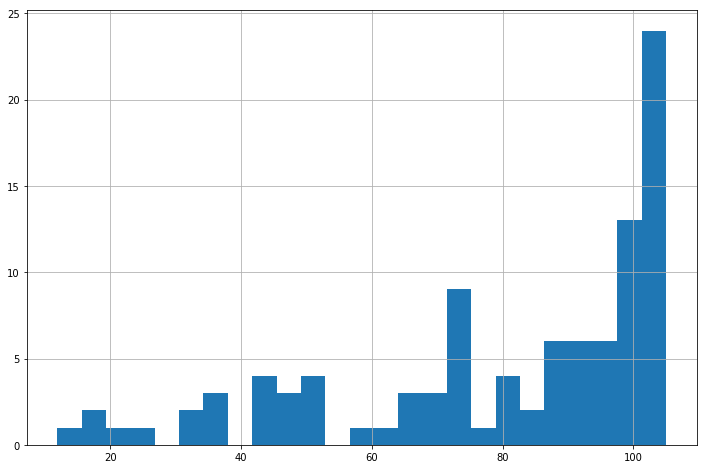

In [11]:
df.Pt0.hist(bins=25)

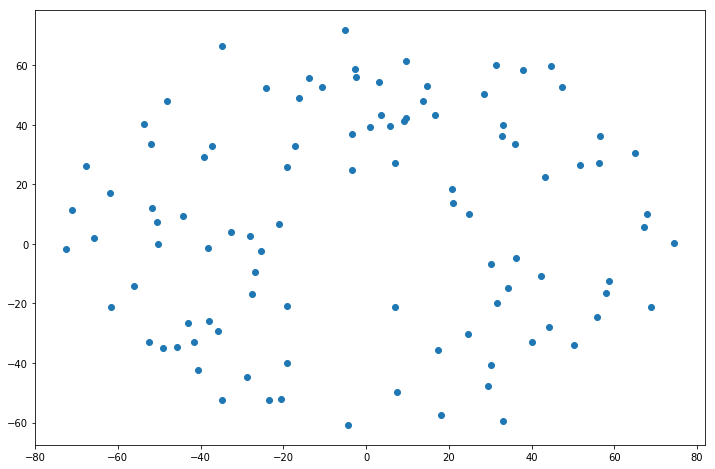

In [12]:
plt.scatter(x=df.X0,y=df.Y0)

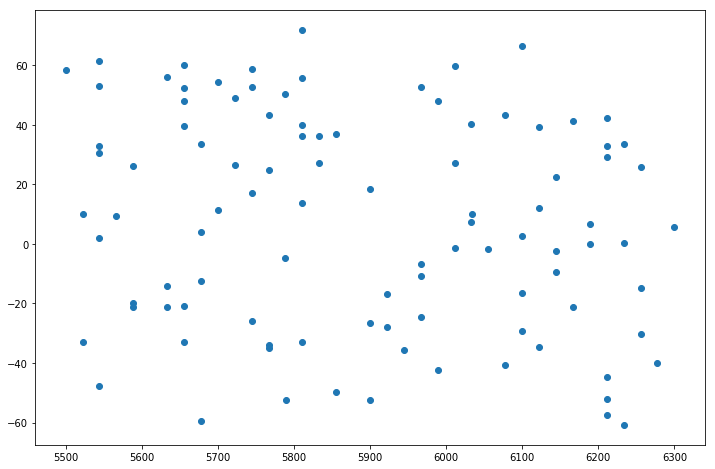

In [13]:
plt.scatter(x=df.Z0,y=df.Y0)

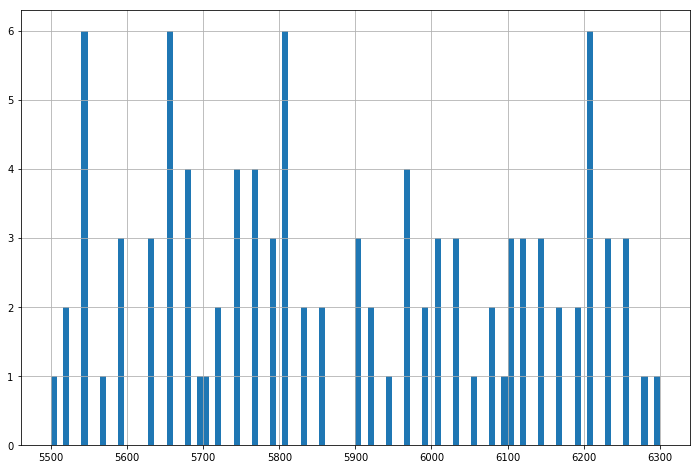

In [14]:
df.Z0.hist(bins=100)

In [42]:
df

,X0,Y0,Z0,Phi0,CosTheta0,Theta0,Px0,Py0,Pz0,Pt0
0,-14.647705,37.616524,5899.977539,1.099080,0.143399,1.426901,47.220498,92.566266,15.056922,103.914817
1,23.620117,23.873680,5722.189941,6.090903,0.494710,1.053295,89.569399,-17.438048,51.944559,91.251098
2,-9.940674,66.988113,5766.657715,1.065133,0.239092,1.329366,49.385568,89.195414,25.104658,101.954677
3,38.080566,1.296604,6100.037109,2.087748,0.675679,0.828911,-38.256335,67.291008,70.946269,77.405600
4,34.759766,3.226178,5566.687012,1.108421,0.643033,0.872344,35.870254,71.969286,67.518492,80.413016
5,-28.667969,-36.301380,5811.079590,6.026849,-0.614701,2.232804,80.113697,-20.997954,-64.543641,82.819795
6,66.123047,25.369076,5722.238770,4.664505,-0.348496,1.926763,-4.710785,-98.304765,-36.592098,98.417571
7,53.149902,33.059135,5500.024414,4.035997,-0.342071,1.919917,-61.763168,-76.943125,-35.917496,98.665766
8,9.153076,35.646210,5944.477539,0.452865,-0.961317,2.862540,26.006304,12.654490,-100.938278,28.921687
9,-11.272949,20.334005,5611.120605,1.557317,0.615467,0.907818,1.115498,82.749568,64.624026,82.757086


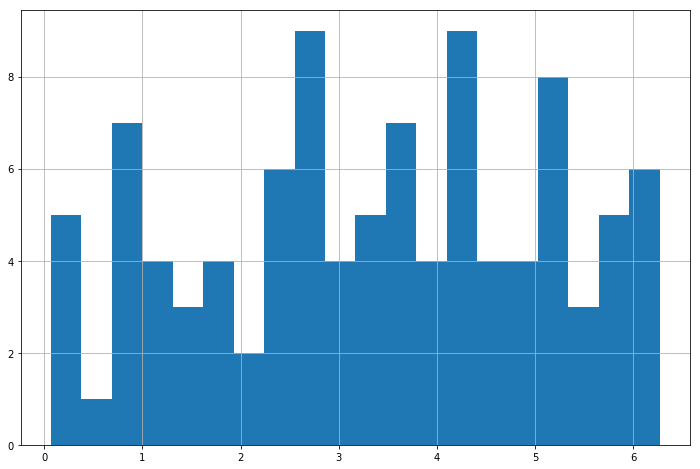

In [15]:
df.Phi0.hist(bins=20)

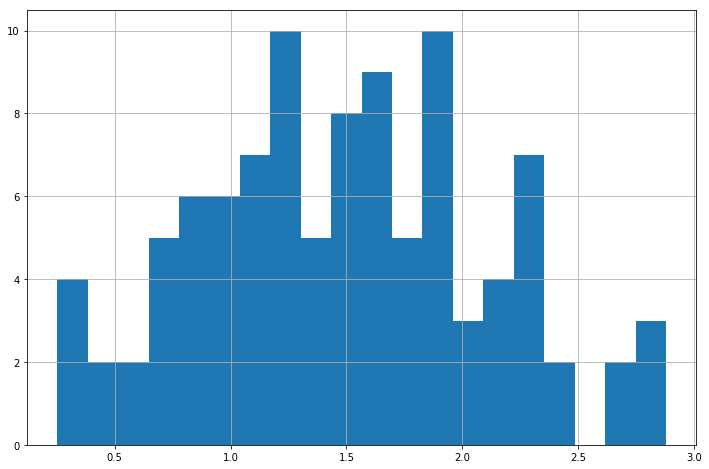

In [44]:
df.Theta0.hist(bins=20)

Let's also dump the generating dataframe to pickle:

In [9]:
save_dir = "/home/ckampa/Coding/Mu2E_Extras/trajectory/run03/"
run_name = "trajectory_run03_10e-11step_Dop853_"

In [46]:
pkl.dump(df, open(save_dir+run_name+'INIT_COND.p','wb'))

Now we are ready to go!

In [29]:
#timesteps = np.linspace(0,4e-8,4000)
timesteps = np.linspace(0,4e-8,4000)

In [30]:
start = time.time()
for i,row in tqdm_notebook(enumerate(df.iloc[[1]].itertuples()), desc='particle #'):
    #print (i, row.X0)
    mom = np.array([row.Px0,row.Py0,row.Pz0])
    pos = np.array([row.X0,row.Y0,row.Z0])
    rtol = 1e-5
    atol = 1e-3
    swimmer = ElectronSwimmer(mom,pos,mag_field_func,timesteps,'Dop853',rtol=rtol,atol=atol)
    #swimmer = ElectronSwimmer(mom,pos,mag_field_func,timesteps,'Dop853',rtol=rtol,atol=atol)
    X, t = swimmer.solve()
    df_out = pd.DataFrame(X,columns=['X','Y','Z','Vx','Vy','Vz'])
    df_out['time'] = t
    df_out['event'] = i
    df_out.event = df_out.event.astype('category')
    df_out['E0'] = swimmer.init_E
    df_out['EF'] = swimmer.final_E
    pkl.dump(df_out,open(save_dir+run_name+f"{i:03d}_TESTING.p",'wb'))
stop = time.time()

swimming electron with [ 89.17044479 -54.03255115  12.41431398] MeV, starting at [ -23.57373047  -52.28263855 5788.93701172] mm, for 4e-08 s
init energy: 105.00124342646296 MeV
final energy: 105.53504499774861 MeV
energy difference: 0.5338015712856503 MeV (0.5084%)



Only had time for 75 particles before FMS #53.

In [58]:
# testing it all worked for 1
df_out = pkl.load(open(save_dir+run_name+'000.p','rb'))

In [59]:
df_out

,X,Y,Z,Vx,Vy,Vz,time,event,E0,EF
0,-14.647705,37.616524,5899.977539,1.348208e+11,2.642890e+11,4.298951e+10,0.000000e+00,0,105.001243,109.43521
1,-13.315936,40.268547,5900.407514,1.314621e+11,2.659765e+11,4.298407e+10,1.000250e-11,0,105.001243,109.43521
2,-12.017866,42.937235,5900.837437,1.280827e+11,2.676210e+11,4.297897e+10,2.000500e-11,0,105.001243,109.43521
3,-10.753699,45.622158,5901.267310,1.246832e+11,2.692224e+11,4.297419e+10,3.000750e-11,0,105.001243,109.43521
4,-9.523634,48.322881,5901.697136,1.212641e+11,2.707804e+11,4.296972e+10,4.001000e-11,0,105.001243,109.43521
5,-8.327865,51.038970,5902.126920,1.178259e+11,2.722947e+11,4.296554e+10,5.001250e-11,0,105.001243,109.43521
6,-7.166579,53.769987,5902.556663,1.143693e+11,2.737651e+11,4.296164e+10,6.001500e-11,0,105.001243,109.43521
7,-6.039957,56.515491,5902.986368,1.108947e+11,2.751915e+11,4.295800e+10,7.001750e-11,0,105.001243,109.43521
8,-4.948178,59.275041,5903.416039,1.074028e+11,2.765735e+11,4.295462e+10,8.002001e-11,0,105.001243,109.43521
9,-3.891410,62.048193,5903.845676,1.038941e+11,2.779111e+11,4.295147e+10,9.002251e-11,0,105.001243,109.43521


In [8]:
from hallprobecalib.hpcplots import scatter2d, scatter3d, histo

In [31]:
scatter3d(df_out.X,df_out.Y,df_out.Z,scale_list=[df_out.time],mode_list=['markers+lines'],units_list=[('mm','mm','mm')],inline=True)

Figure({
    'data': [{'marker': {'cauto': False,
                         'cmax': 4e-08,
                         'cmin': 0.0,
                         'color': array([0.00000000e+00, 1.00025006e-11, 2.00050013e-11, ..., 3.99799950e-08,
                                         3.99899975e-08, 4.00000000e-08]),
                         'colorbar': {'thickness': 20, 'title': 'time (mm)', 'x': -0.1, 'y': 0.5},
                         'colorscale': 'Viridis',
                         'opacity': 0.8,
                         'reversescale': False,
                         'showscale': True,
                         'size': 2},
              'mode': 'markers+lines',
              'name': '<br>x: X (mm)<br>y: Y (mm)<br>z: Z (mm)<br>',
              'type': 'scatter3d',
              'uid': 'cecb65f5-9129-490d-8709-d6e71459b0d6',
              'x': array([-23.57373047, -21.01726607, -18.44129515, ...,  77.04929463,
                           79.98150141,  82.91537939]),
              'y': ar

Great! But this takes far too long...bottlenecked by B-field calculation.

In [32]:
%timeit mag_field_func(10,10,6000)

2.01 ms ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Goal: beat this down by a factor of 10.

In [10]:
df_out = pkl.load(open(save_dir+run_name+'000_TESTING.p','rb'))

In [11]:
df_out.eval('R = (X**2+Y**2)**(1/2)',inplace=True)

In [14]:
df_small = df_out[::10]

In [15]:
df_small

,X,Y,Z,Vx,Vy,Vz,time,event,E0,EF,R
0,-23.573730,-52.282639,5788.937012,2.545934e+11,-1.542701e+11,3.544451e+10,0.000000e+00,0,105.001243,105.535045,57.351504
10,2.816048,-66.027968,5792.486285,2.723335e+11,-1.201915e+11,3.552221e+10,1.000250e-10,0,105.001243,105.535045,66.087992
20,30.755000,-76.261180,5796.042973,2.855288e+11,-8.414201e+10,3.559247e+10,2.000500e-10,0,105.001243,105.535045,82.229177
30,59.777532,-82.814843,5799.606342,2.939713e+11,-4.672125e+10,3.565625e+10,3.000750e-10,0,105.001243,105.535045,102.135457
40,89.401070,-85.582784,5803.175886,2.975308e+11,-8.551517e+09,3.571640e+10,4.001000e-10,0,105.001243,105.535045,123.761723
50,119.134029,-84.521723,5806.751368,2.961578e+11,2.973376e+10,3.577530e+10,5.001250e-10,0,105.001243,105.535045,146.071347
60,148.483954,-79.651819,5810.332747,2.898842e+11,6.750124e+10,3.583454e+10,6.001500e-10,0,105.001243,105.535045,168.498952
70,176.965662,-71.056176,5813.920114,2.788232e+11,1.041275e+11,3.589516e+10,7.001750e-10,0,105.001243,105.535045,190.698258
80,204.109236,-58.879294,5817.513643,2.631665e+11,1.390101e+11,3.595784e+10,8.002001e-10,0,105.001243,105.535045,212.431993
90,229.467750,-43.324503,5821.113562,2.431817e+11,1.715763e+11,3.602298e+10,9.002251e-10,0,105.001243,105.535045,233.521864


In [16]:
df = df_small
scatter3d(df.X,df.Y,df.Z,scale_list=[df.time],mode_list=['markers+lines'],units_list=[('mm','mm','mm')],inline=True)

Figure({
    'data': [{'marker': {'cauto': False,
                         'cmax': 3.990997749437359e-08,
                         'cmin': 0.0,
                         'color': array([0.00000000e+00, 1.00025006e-10, 2.00050013e-10, ..., 3.97099275e-08,
                                         3.98099525e-08, 3.99099775e-08]),
                         'colorbar': {'thickness': 20, 'title': 'time (mm)', 'x': -0.1, 'y': 0.5},
                         'colorscale': 'Viridis',
                         'opacity': 0.8,
                         'reversescale': False,
                         'showscale': True,
                         'size': 2},
              'mode': 'markers+lines',
              'name': '<br>x: X (mm)<br>y: Y (mm)<br>z: Z (mm)<br>',
              'type': 'scatter3d',
              'uid': '2b4c1028-cac2-49ea-a996-42daf29243ea',
              'x': array([-23.57373047,   2.81604756,  30.75499985, ...,  -0.54512077,
                           27.70835526,  56.5924291 ]),
     

In [17]:
df_small.head(1)

,X,Y,Z,Vx,Vy,Vz,time,event,E0,EF,R
0,-23.57373,-52.282639,5788.937012,2.545934e+11,-1.542701e+11,3.544451e+10,0.0,0,105.001243,105.535045,57.351504


In [18]:
(df_small.head(1).EF-df_small.head(1).E0)/df_small.head(1).E0

0    0.005084
dtype: float64

In [22]:
mom = [89.17044479,-54.03255115,12.41431398]
p = np.sqrt(np.dot(mom,mom))
pt = np.sqrt(mom[0]**2+mom[1]**2)

In [21]:
p

104.99999999722775

In [23]:
pt

104.26353536986842